# Layers

This notebook introduces a set of layers commonly found in CNNs:

- Batch Normalization
- Dropout
- Pooling



## References

### Batch Normalization
- Original paper: Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift
Sergey Ioffe, Christian Szegedy
https://arxiv.org/abs/1502.03167

- Video [Why does Batch Norm work?](https://www.youtube.com/watch?v=nUUqwaxLnWs) Andrew Ng

- PyTorch: 
torch.nn.BatchNorm2d
https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html


- A Gentle Introduction to Batch Normalization for Deep Neural Networks, Jason Brownlee, https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/

### Dropout
- Original paper: Improving neural networks by preventing co-adaptation of feature detectors (2012)
G. E. Hinton∗ , N. Srivastava, A. Krizhevsky, I. Sutskever and R. R. Salakhutdinov
https://arxiv.org/pdf/1207.0580.pdf

- More evaluation: Dropout: A Simple Way to Prevent Neural Networks from Overfitting (2014)
Nitish Srivastava, Geoffrey Hinton, Alex Krizhevsky, Ilya Sutskever, Ruslan Salakhutdinov
https://jmlr.org/papers/v15/srivastava14a.html

- A Gentler Article: A Gentle Introduction to Dropout for Regularizing Deep Neural Networks (2018)
Jason Brownlee
https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/

- Another Gentle Article: Understanding And Implementing Dropout In TensorFlow And Keras
Richmond Alake
https://towardsdatascience.com/understanding-and-implementing-dropout-in-tensorflow-and-keras-a8a3a02c1bfa


### Pooling

- Evaluation of Pooling Operations in Convolutional Architectures for Object Recognition
Dominik Scherer, Andreas Muller, and Sven Behnke
http://ais.uni-bonn.de/papers/icann2010_maxpool.pdf

- An alernative to pooling: Striving for Simplicity: The All Convolutional Net, Jost Tobias Springenberg, Alexey Dosovitskiy, Thomas Brox, Martin Riedmiller, https://arxiv.org/abs/1412.6806

- A Gentle Introduction to Pooling Layers for Convolutional Neural Networks, Jason Brownlee, https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/




In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import torchinfo

import matplotlib.pyplot as plt
import numpy as np
import time

# importing a module with utilities for displaying stats and data
import sys
sys.path.insert(1, './util')
import vcpi_util

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
print(device)

BATCH_SIZE = 128
EPOCHS = 20


cuda:0


In [3]:
transform = transforms.Compose([transforms.ToTensor()])
# TREINO
train_set = torchvision.datasets.MNIST(root='./data',train = True, download= True, transform = transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle= True)

# TESTE
test_set = torchvision.datasets.MNIST(root='./data',train = False, download= True, transform = transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle= False)

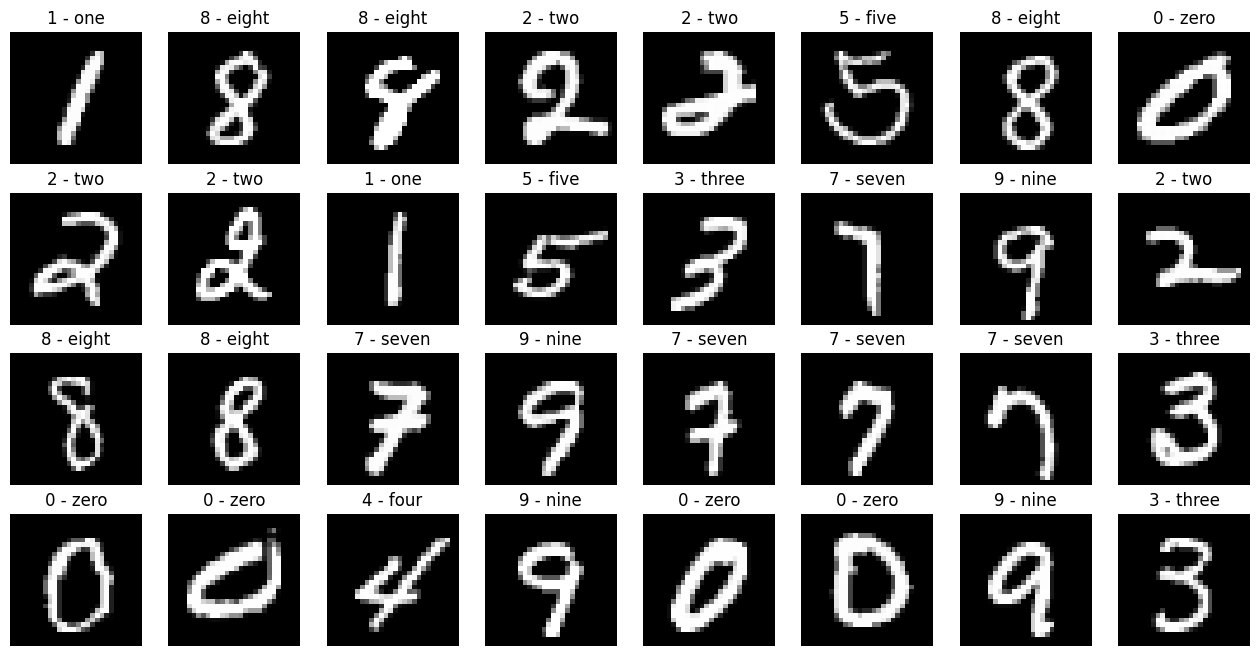

<Figure size 640x480 with 0 Axes>

In [4]:
images, targets = next(iter(train_loader))

vcpi_util.show_images(4, 8, images, targets, train_set.classes)

In [5]:
def train(model, data_loader, epochs, loss_fn, optimizer):
    
    model.train()

    history = {}
    history["accuracy"] = []
    history["loss"] = []

    for epoch in range(epochs):
        start_time = time.time()
        correct = 0
        running_loss = 0

        for i, (inputs, targets) in enumerate(data_loader, 0):
            
            # PASSA PARA GPU
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)

            loss = loss_fn(outputs, targets)
            optimizer.zero_grad()

            loss.backward()

            optimizer.step()
            
            # ESTATISTICAS
            _,pred = torch.max(outputs, 1)
            correct += (pred == targets).sum()

            running_loss += loss

        accuracy = 100 * correct/len(train_set)
        stop_time = time.time()

        print(f'Epoch: {epoch:03d} Acc = {accuracy:0.4f} Time = {(stop_time - start_time):0.4f}')
        history['accuracy'].append(accuracy.cpu().numpy())
        history["loss"].append(running_loss.cpu().detach().numpy())
    return history

In [6]:
def evaluate(model, data_loader):
    model.eval()

    correct = 0

    for i, (images, targets) in enumerate(data_loader):

        logits = model(images.to(device))

        _,pred = torch.max(logits, dim = 1)

        correct +=(pred.cpu() == targets).sum()

    return (correct *100.0/len(data_loader.dataset)).item()

In [9]:
class Conv(torch.nn.Module):
    def __init__(self, num_classes):

        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 16, 3)
        self.relu1 = torch.nn.ReLU()

        self.conv2 = torch.nn.Conv2d(16, 32, 3)
        self.relu2 = torch.nn.ReLU()
        
        self.conv3 = torch.nn.Conv2d(32, 48, 3)
        self.relu3 = torch.nn.ReLU()
        
        self.conv4 = torch.nn.Conv2d(48, 48, 3)
        self.relu4 = torch.nn.ReLU()

        self.fc1 = torch.nn.Linear(19200, num_classes)

    def forward(self,x):
        # input = (bs, 1, 28, 28)

        x = self.conv1(x) # -> (bs, 16, 26, 26)
        x = self.relu1(x)
        
        x = self.conv2(x) # -> (bs, 32, 24, 24)
        x = self.relu2(x)
        
        x = self.conv3(x) # -> (bs, 48, 22, 22)
        x = self.relu3(x)
        
        x = self.conv4(x) # -> (bs, 48, 20, 20)
        x = self.relu4(x)
        
        x = torch.flatten(x, 1) # Gera um array bs 19200
        x = self.fc1(x) # -> bs, 19200 para bs, 10


        return (x)
    
model_conv = Conv(len(train_set.classes))
model_conv.to(device)
print(model_conv)

torchinfo.summary(model_conv,input_size = (BATCH_SIZE, 1, 28, 28))

Conv(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1))
  (relu3): ReLU()
  (conv4): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1))
  (relu4): ReLU()
  (fc1): Linear(in_features=19200, out_features=10, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
Conv                                     [128, 10]                 --
├─Conv2d: 1-1                            [128, 16, 26, 26]         160
├─ReLU: 1-2                              [128, 16, 26, 26]         --
├─Conv2d: 1-3                            [128, 32, 24, 24]         4,640
├─ReLU: 1-4                              [128, 32, 24, 24]         --
├─Conv2d: 1-5                            [128, 48, 22, 22]         13,872
├─ReLU: 1-6                              [128, 48, 22, 22]         --
├─Conv2d: 1-7                            [128, 48, 20, 20]         20,784
├─ReLU: 1-8                              [128, 48, 20, 20]         --
├─Linear: 1-9                            [128, 10]                 192,010
Total params: 231,466
Trainable params: 231,466
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 2.30
Input size (MB): 0.40
Forward/backward pass size (MB): 73.41
Params size (MB): 0.93
Estimated To

In [11]:
train_acc = []

optimizer_C = torch.optim.Adam(model_conv.parameters())
loss_fn = torch.nn.CrossEntropyLoss()

history_C = train(model_conv, train_loader, EPOCHS, loss_fn, optimizer_C)

train_acc.append(history_C["accuracy"][-1])



Epoch: 000 Acc = 99.8783 Time = 8.7282
Epoch: 001 Acc = 99.9017 Time = 8.3892
Epoch: 002 Acc = 99.9017 Time = 8.3855
Epoch: 003 Acc = 99.9017 Time = 8.3665
Epoch: 004 Acc = 99.9183 Time = 8.7529
Epoch: 005 Acc = 99.9433 Time = 8.2527
Epoch: 006 Acc = 99.9733 Time = 8.1628
Epoch: 007 Acc = 99.9350 Time = 8.6008
Epoch: 008 Acc = 99.8900 Time = 8.6660
Epoch: 009 Acc = 99.9350 Time = 9.8821
Epoch: 010 Acc = 99.8717 Time = 8.6111
Epoch: 011 Acc = 99.9583 Time = 8.3846
Epoch: 012 Acc = 99.9800 Time = 8.3701
Epoch: 013 Acc = 99.9400 Time = 8.2415
Epoch: 014 Acc = 99.9083 Time = 8.3584
Epoch: 015 Acc = 99.9450 Time = 8.5079
Epoch: 016 Acc = 99.9633 Time = 8.1807
Epoch: 017 Acc = 99.9400 Time = 8.4385
Epoch: 018 Acc = 99.9233 Time = 8.2169
Epoch: 019 Acc = 99.9700 Time = 8.4137


In [12]:
eval_acc = []

eval_acc.append(evaluate(model_conv,test_loader))
print(eval_acc)

[98.80999755859375]


In [15]:
torch.save(
    {
        "model": model_conv.state_dict(),
        "optimizer": optimizer_C.state_dict(),
    },
    f"model_conv_simple_.pt",
)

In [17]:
class Conv_II(torch.nn.Module):
    def __init__(self, num_classes):

        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 16, 3)
        self.bn1 = torch.nn.BatchNorm2d(16)
        self.relu1 = torch.nn.ReLU()

        self.conv2 = torch.nn.Conv2d(16, 32, 3)
        self.bn2 = torch.nn.BatchNorm2d(32)
        self.relu2 = torch.nn.ReLU()

        self.maxpool1 = torch.nn.MaxPool2d(2) 
        
        self.conv3 = torch.nn.Conv2d(32, 48, 3)
        self.bn3 = torch.nn.BatchNorm2d(48)
        self.relu3 = torch.nn.ReLU()
        
        self.conv4 = torch.nn.Conv2d(48, 48, 3)
        self.bn4 = torch.nn.BatchNorm2d(48)
        self.relu4 = torch.nn.ReLU()
        
        self.maxpool2 = torch.nn.MaxPool2d(2)


        self.fc1 = torch.nn.Linear(768, num_classes)

    def forward(self,x):
        # input = (bs, 1, 28, 28)

        x = self.conv1(x) # -> (bs, 16, 26, 26)
        x = self.bn1(x)
        x = self.relu1(x)
        
        x = self.conv2(x) # -> (bs, 32, 24, 24)
        x = self.bn2(x)
        x = self.relu2(x)
        
        x = self.maxpool1(x) # -> bs(32 canais, 12 x 12)

        x = self.conv3(x) # -> (bs, 48, 10, 10)
        x = self.bn3(x)
        x = self.relu3(x)
        
        x = self.conv4(x) # -> (bs, 48, 8, 8)
        x = self.bn4(x)
        x = self.relu4(x)

        x = self.maxpool2(x) # -> bs(32 canais, 4 x 4)
        
        x = torch.flatten(x, 1) # Gera um array bs 48 * 4 * 4
        x = self.fc1(x) # -> bs, 768 para bs, 10


        return (x)
    
model_conv_II = Conv_II(len(train_set.classes))
model_conv_II.to(device)
print(model_conv_II)

torchinfo.summary(model_conv_II,input_size = (BATCH_SIZE, 1, 28, 28))

Conv_II(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (conv4): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=768, out_features=10, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
Conv_II                                  [128, 10]                 --
├─Conv2d: 1-1                            [128, 16, 26, 26]         160
├─BatchNorm2d: 1-2                       [128, 16, 26, 26]         32
├─ReLU: 1-3                              [128, 16, 26, 26]         --
├─Conv2d: 1-4                            [128, 32, 24, 24]         4,640
├─BatchNorm2d: 1-5                       [128, 32, 24, 24]         64
├─ReLU: 1-6                              [128, 32, 24, 24]         --
├─MaxPool2d: 1-7                         [128, 32, 12, 12]         --
├─Conv2d: 1-8                            [128, 48, 10, 10]         13,872
├─BatchNorm2d: 1-9                       [128, 48, 10, 10]         96
├─ReLU: 1-10                             [128, 48, 10, 10]         --
├─Conv2d: 1-11                           [128, 48, 8, 8]           20,784
├─BatchNorm2d: 1-12                      [128, 48, 8, 8]           96
├─R

In [21]:
optimizer_C_II = torch.optim.Adam(model_conv_II.parameters())

history_C_II = train(model_conv_II,train_loader,EPOCHS,loss_fn,optimizer_C_II)
train_acc.append(history_C_II['accuracy'][-1])

Epoch: 000 Acc = 96.7883 Time = 9.0295
Epoch: 001 Acc = 98.8850 Time = 8.8609
Epoch: 002 Acc = 99.1700 Time = 8.9380
Epoch: 003 Acc = 99.3383 Time = 9.3310
Epoch: 004 Acc = 99.5150 Time = 8.8717
Epoch: 005 Acc = 99.5367 Time = 8.7935
Epoch: 006 Acc = 99.6483 Time = 8.8168
Epoch: 007 Acc = 99.7033 Time = 8.8887
Epoch: 008 Acc = 99.7333 Time = 9.0202
Epoch: 009 Acc = 99.7517 Time = 8.8895
Epoch: 010 Acc = 99.7650 Time = 9.2783
Epoch: 011 Acc = 99.8500 Time = 9.1237
Epoch: 012 Acc = 99.8267 Time = 8.9195
Epoch: 013 Acc = 99.7950 Time = 8.9349
Epoch: 014 Acc = 99.8567 Time = 9.0041
Epoch: 015 Acc = 99.9450 Time = 8.9943
Epoch: 016 Acc = 99.8233 Time = 8.9508
Epoch: 017 Acc = 99.8367 Time = 8.9691
Epoch: 018 Acc = 99.8733 Time = 9.1676
Epoch: 019 Acc = 99.8833 Time = 8.9456


In [22]:
eval_acc.append(evaluate(model_conv_II, test_loader))
print(eval_acc)


[98.80999755859375, 99.36000061035156]
